# Import

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

path = "drive/My Drive/Churn/dataset/"


In [55]:
features = pd.read_csv(path+'walmart/features.csv')
stores = pd.read_csv(path+'walmart/stores.csv')
data_train = pd.read_csv(path+'walmart/train.csv')

# EDA Dataset

## Join Feature

In [56]:
# Join the DataFrames in pandas
dataset = pd.merge(data_train, stores, on='Store', how='inner')
dataset = pd.merge(dataset, features.drop('IsHoliday', axis=1), on=['Date', 'Store'], how='left')

# Convert the 'Date' column to datetime
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Convert 'CPI' and 'Unemployment' columns to numeric with downcasting
dataset["CPI"] = pd.to_numeric(dataset["CPI"], downcast="float")
dataset["Unemployment"] = pd.to_numeric(dataset["Unemployment"], downcast="float")

# Set the 'Date' column as the index
dataset.set_index('Date', inplace=True)

# Display the first few rows of the resulting pandas DataFrame
dataset.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096359,8.106
2010-02-12,1,1,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242172,8.106
2010-02-19,1,1,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289139,8.106
2010-02-26,1,1,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319641,8.106
2010-03-05,1,1,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [57]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  bool   
 4   Type          421570 non-null  object 
 5   Size          421570 non-null  int64  
 6   Temperature   421570 non-null  float64
 7   Fuel_Price    421570 non-null  float64
 8   MarkDown1     150681 non-null  float64
 9   MarkDown2     111248 non-null  float64
 10  MarkDown3     137091 non-null  float64
 11  MarkDown4     134967 non-null  float64
 12  MarkDown5     151432 non-null  float64
 13  CPI           421570 non-null  float32
 14  Unemployment  421570 non-null  float32
dtypes: bool(1), float32(2), float64(8), int64(3), object(1)
memory usage: 45.4+ MB


## Check duplicated

In [58]:
dataset.duplicated().any()

False

## Check missing value

In [59]:
dataset.isna().any()

Store           False
Dept            False
Weekly_Sales    False
IsHoliday       False
Type            False
Size            False
Temperature     False
Fuel_Price      False
MarkDown1        True
MarkDown2        True
MarkDown3        True
MarkDown4        True
MarkDown5        True
CPI             False
Unemployment    False
dtype: bool

## Visualizations

In [60]:
binary_list = dataset.select_dtypes(include=['object']).columns
numerical_list = dataset.select_dtypes(include=['int64', 'float64'])


### Univariate Analysis

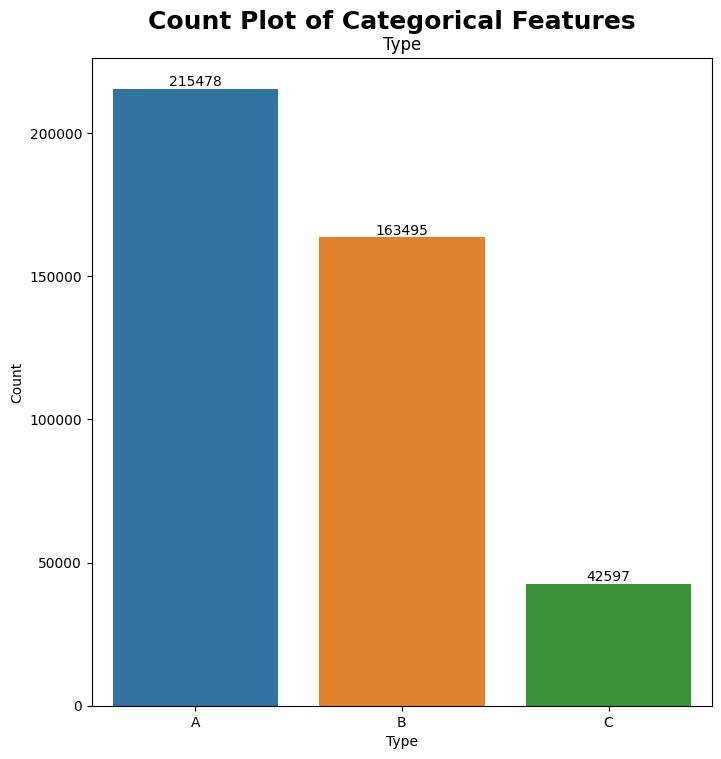

In [61]:
fig = plt.figure(figsize=[8, 8])
fig.suptitle('Count Plot of Categorical Features', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92)
fig.subplots_adjust(hspace=0.5, wspace=0.4)

# Adjust the grid size to accommodate more subplots
num_rows = 1  # You may need to adjust this based on the number of features
num_cols = 1

for i, column in enumerate(binary_list[:num_rows * num_cols]):
    input = np.unique(dataset[column], return_counts=True)
    ax = fig.add_subplot(num_rows, num_cols, i + 1)
    sns.barplot(x=list(input[0]), y=list(input[1]), ax=ax)
    ax.set_title(f'{column}')
    ax.set_xlabel(f'{column}')
    ax.set_ylabel('Count')
    ax.bar_label(ax.containers[0])

plt.show()


### Numerical Analysis

#### Sales Data

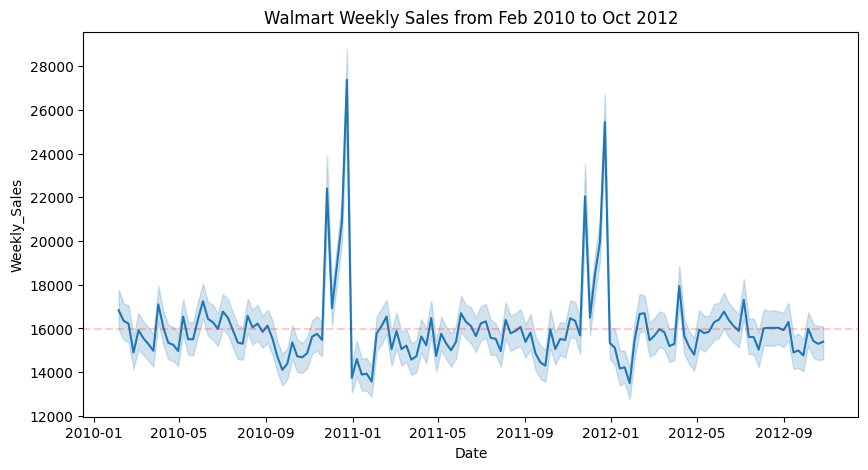

In [62]:
plt.figure(figsize=(10,5))
sns.lineplot(data=dataset,
             x='Date',
             y='Weekly_Sales',
            ).set_title('Walmart Weekly Sales from Feb 2010 to Oct 2012')
plt.axhline(dataset['Weekly_Sales'].mean(), color='r', alpha=0.2, linestyle='--')
plt.show()

1. We see a spike in Sales during the holiday season (November to December) every year
2. We can see the sales is not decreasing over the years

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_weekly_sales_by_ranges(dataset, X, Y, title):
    # Get the minimum and maximum dates in the dataset
    min_date = dataset.index.min()
    max_date = dataset.index.max()

    # Set the interval for each plot (e.g., 1 year)
    interval = pd.DateOffset(years=1)

    # Precompute date ranges
    date_ranges = [(start, start + interval) for start in pd.date_range(min_date, max_date, freq=interval)]

    # Create a single figure for all plots
    fig, axes = plt.subplots(len(date_ranges), 1, figsize=(10, 4 * len(date_ranges)))

    # Create a loop to generate subplots for each date range
    for i, (start_date, end_date) in enumerate(date_ranges):
        # Filter the dataset based on the current date range
        filtered_data = dataset.loc[(dataset.index >= start_date) & (dataset.index < end_date)]

        # Plot the line chart for the current date range in the i-th subplot
        sns.lineplot(data=filtered_data, x=X, y=Y, ax=axes[i])
        axes[i].set_title(f' {title} {start_date.date()} to {end_date.date()}')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()



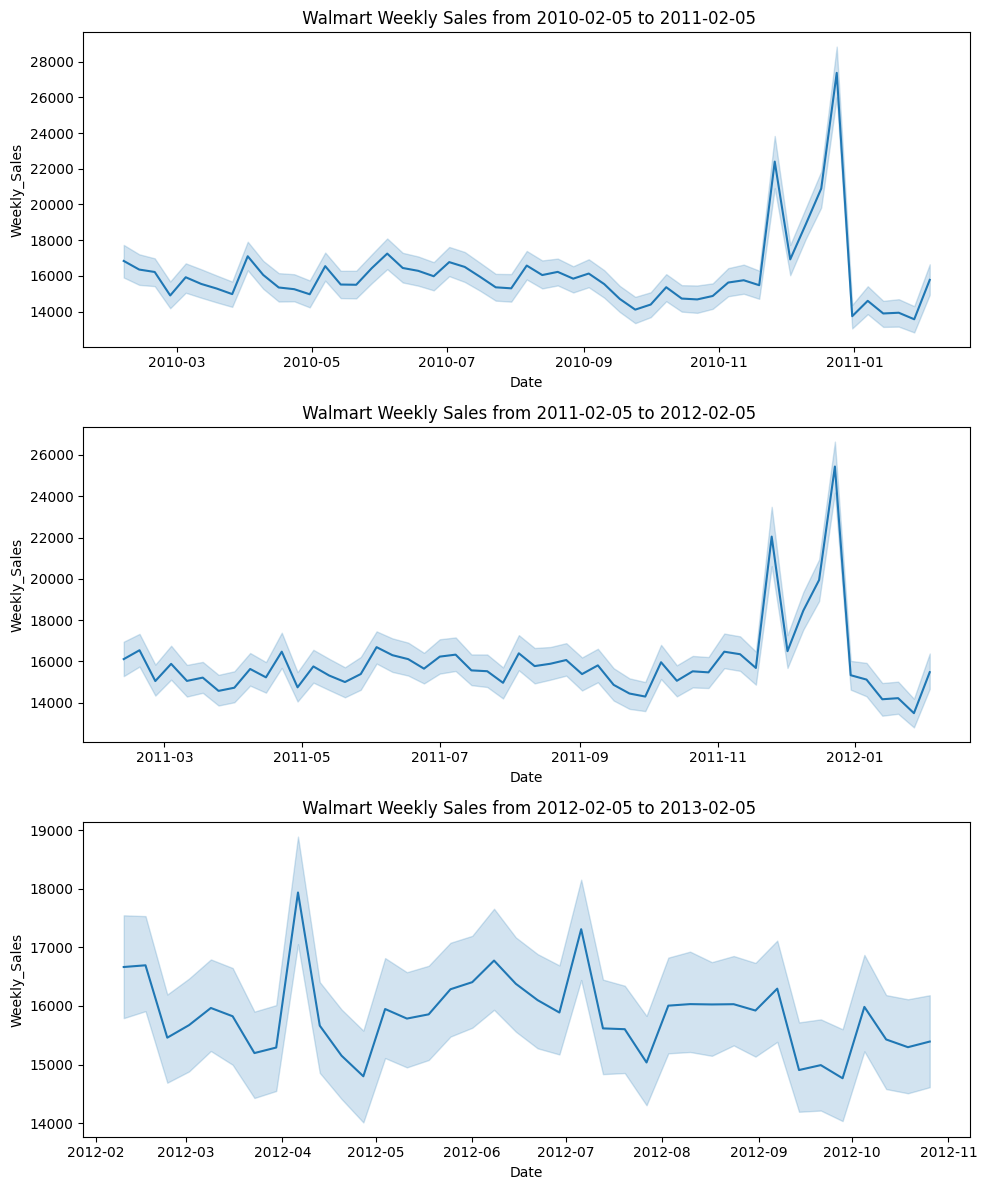

In [64]:
plot_weekly_sales_by_ranges(dataset,'Date','Weekly_Sales','Walmart Weekly Sales from')


Only 2013 year that don't have best sales on Nov-Dec, but because It may be we don't have data on Nov - Dec.

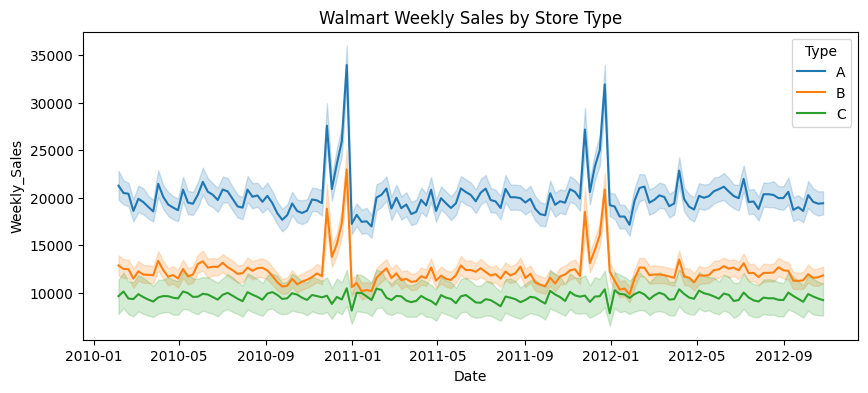

In [65]:
plt.figure(figsize=(10,4))
sns.lineplot(data=dataset,
             x='Date',
             y='Weekly_Sales',
             hue='Type'
            ).set_title('Walmart Weekly Sales by Store Type')
plt.show()

Bigger stores (A) have higher sales compared to smaller stores (B)


#### Temperature

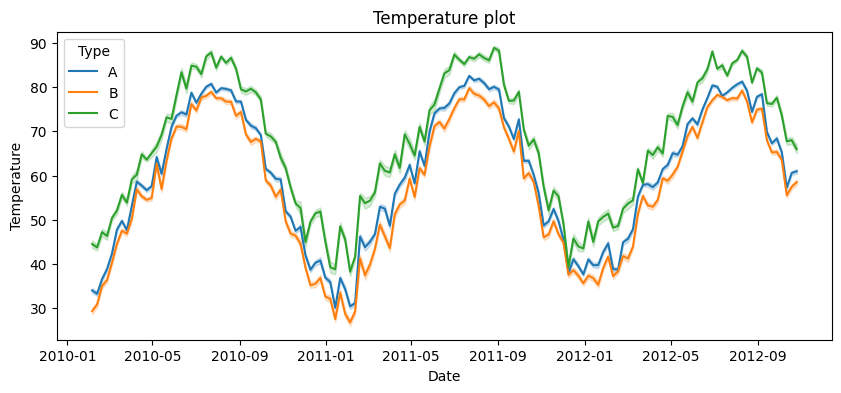

In [66]:
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(data=dataset,
             x='Date',
             y='Temperature',
             hue='Type',
             ax=ax,
            ).set_title('Temperature plot')
plt.show()


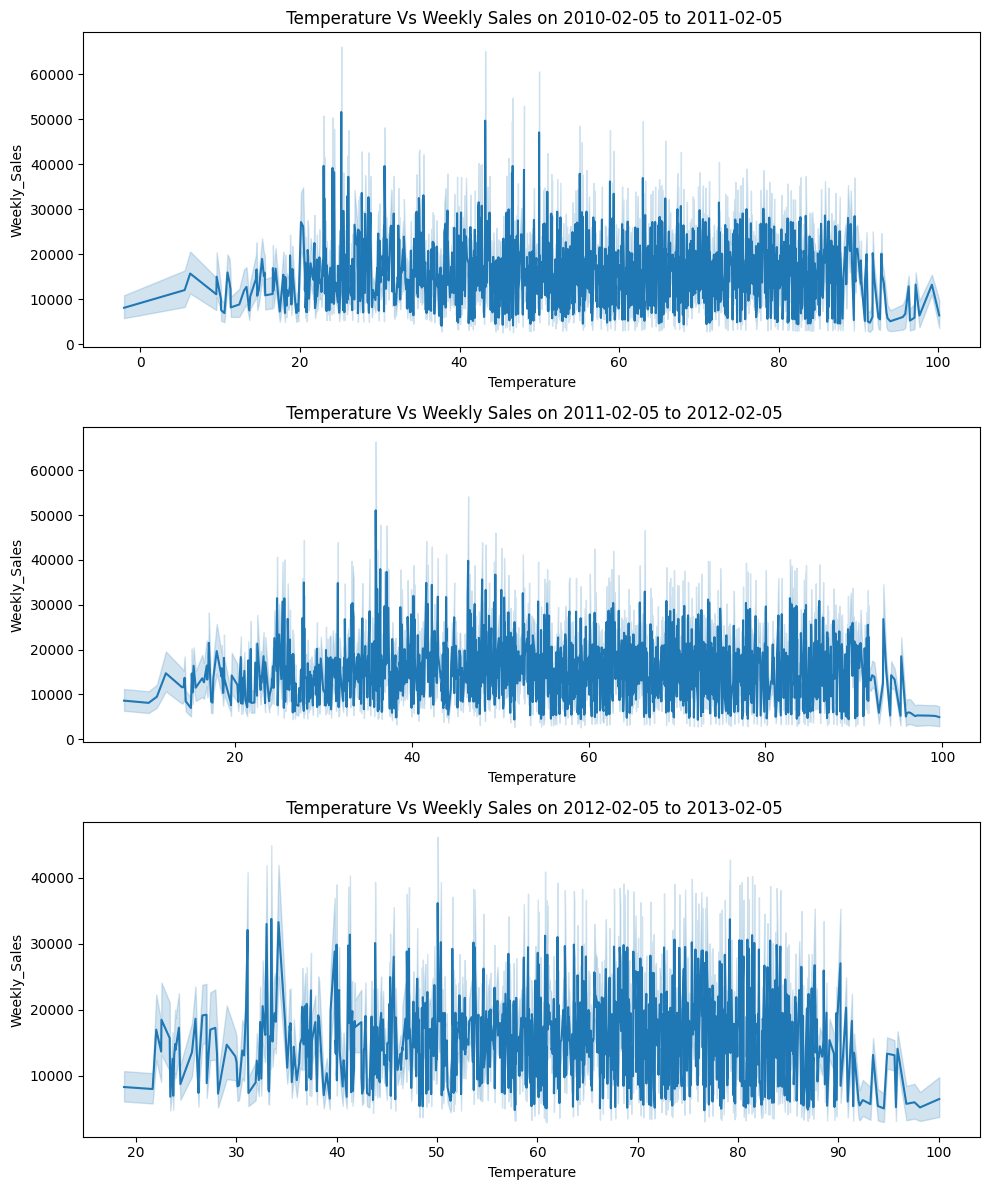

In [67]:
plot_weekly_sales_by_ranges(dataset,'Temperature','Weekly_Sales','Temperature Vs Weekly Sales on')


There is no effect of Temperature on Sales


#### Fuel Price

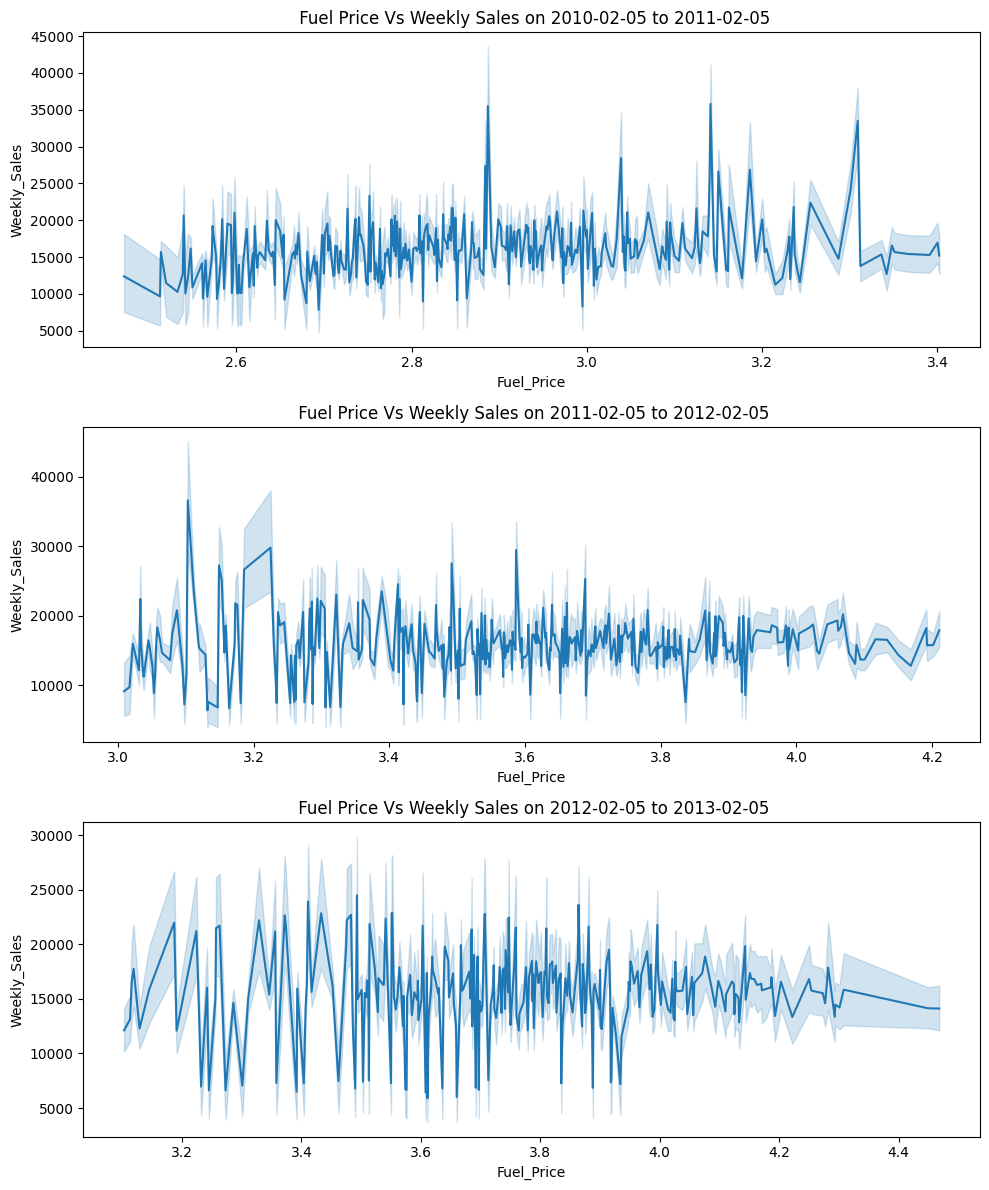

In [68]:
plot_weekly_sales_by_ranges(dataset,'Fuel_Price','Weekly_Sales','Fuel Price Vs Weekly Sales on')


#### CPI

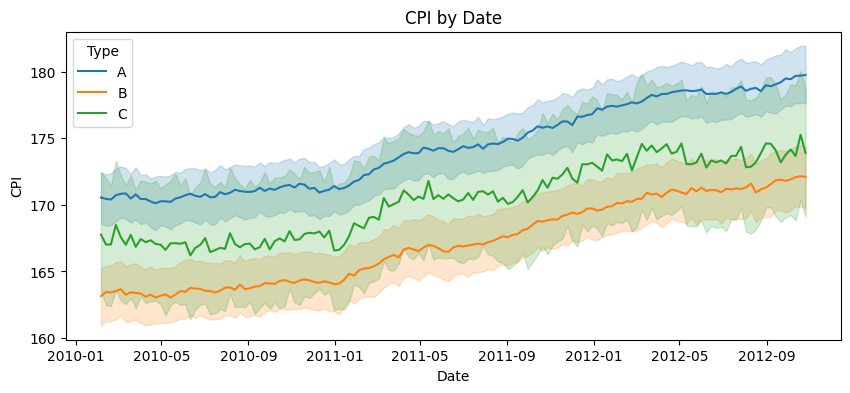

In [69]:
plt.figure(figsize=(10,4))
sns.lineplot(data=dataset,
             x='Date',
             y='CPI',
             hue='Type'
            ).set_title('CPI by Date')
plt.show()

# Machine learning

## Preprocessing

#### Changing Missing Value

- Only MarkDown columns have missing values.
- As they are anonimized offer related sales. We can assume if there is no data (NaN) for a particular day then the value is 0.
- So we can replace nulls with 0.

In [70]:
dataset.fillna(0, inplace=True)

### Converting String / Boolean Columns into Numerical

As we see on Type A has a strong follow B, and last C so we will replace
A -> 2
B -> 1
C -> 0

In [71]:
dataset['IsHoliday'] = dataset['IsHoliday'].astype('int')

In [72]:
dataset['Type'] = dataset['Type'].replace({'C': 0, 'B': 1, 'A': 2})


## Train-Test split

We may not to sclaer due to the data we explore

In [73]:
X = dataset.drop(['Weekly_Sales'],axis=1)
y = dataset['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Cross validation with Linear regression

In [74]:
from sklearn.linear_model import LinearRegression
linear_param_grid = {
    'fit_intercept': [True, False],  # Whether to calculate the intercept
}
linear_regressor = LinearRegression()
linear_random_search  = RandomizedSearchCV(linear_regressor, linear_param_grid, cv=5, scoring='neg_mean_squared_error')
linear_random_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=LinearRegression(),
                   param_distributions={'fit_intercept': [True, False]},
                   scoring='neg_mean_squared_error')

## Cross validation with XG regressor

In [75]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
xgb_param_dist = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}
xgb_regressor = XGBRegressor()

# Perform randomized search
xgb_random_search = RandomizedSearchCV(
    xgb_regressor, xgb_param_dist, n_iter=10, cv=3,
    scoring='neg_mean_squared_error', random_state=42
)
xgb_random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'gamma': [0, 0.1],
                                        'learning_rate': [0.01, 0.1],
                                        'max_depth': [3, 5],
                                        'n_estimators': [50, 100],
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78aa7e807be0>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78aa79703c10>,
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error')

## Display evaluation metrics

In [76]:
## create function for use it later
def evaluate_metrics(all_model,X_test,y_test):
  lst = []
  for name,model in all_model:
    pred = model.predict(X_test)
    lst.append([name,
                      mean_absolute_error(y_test, pred),
                      mean_squared_error(y_test, pred)])
  eval_df = pd.DataFrame(lst, columns=['model', 'MAE ', 'MSE '])
  # eval_df.set_index('model', inplace = True)
  return eval_df

In [77]:
lst1 = [('linear',linear_random_search),('xg',xgb_random_search)]
evl = evaluate_metrics(lst1,X_test,y_test)
result = evl
evl

,model,MAE,MSE
0,linear,14510.863389,4.636344e+08
1,xg,4739.798385,7.315647e+07


## Decrease some Feature

In [78]:
X_train_remove = X_train.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],axis=1)
X_test_remove = X_test.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],axis=1)

In [ ]:
linear_random_search_remove = linear_random_search.fit(X_train_remove,y_train)
xgb_random_search_remove = xgb_random_search.fit(X_train_remove,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [ ]:
lst2 = [('linear remove',linear_random_search),('xg remove',xgb_random_search)]
evl = evaluate_metrics(lst2,X_test_remove,y_test)
result = result.append(evl,ignore_index=True)
evl

# Conclusion

In [ ]:
result

# Save model

In [ ]:
lst1 = [('linear',linear_random_search),('xg',xgb_random_search)]
lst2 = [('linear remove',linear_random_search),('xg remove',xgb_random_search)]

import joblib
result_dict = {
    "lr" : linear_random_search,
    "xg" : xgb_random_search,
    "lrRemove" : linear_random_search,
    "xgRemove":xgb_random_search

}
joblib.dump(result_dict['xgRemove'], 'xgRemove.joblib')
